# Introduction

Gradient descent is a first-order iterative optimization algorithm for finding the minimum of a function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or of the approximate gradient) of the function at the current point.

Standard form of machine learning algorithms often need to optimize a cost function given by:
$$Q(w) = \frac{1}{n}\sum_{i=1}^{n}Q_i(w)$$
where the parameter $w$ needs to be estimated that mimimizes $Q(w)$ and each $Q_i(w)$ represents some function of $i^{th}$ training sample.

The basic structure of gradient descent is very simple and intuitive. We have the cost function $Q(w)$ and we want to minimize the cost function by searching for optimal parameter $w$. This is done by finding the gradient of cost function and move the parameter towards the direction of the gradient. The update can be tuned by using a learning rate $\alpha$ which determines the rate at which the optimization happens.
There are broadly two types of gradient descent approaches:
    1. Batch Gradient Descent
    2. Stochastic Gradient Descent

#### Batch Gradient Descent

In this method, basically the gradient descent is done over the complete training set. So, the cost function is differentiated for each of the $i$ training samples and the update is done. The gradient descent equation looks like the following:
$$w = w - \alpha * \nabla Q(w) = w - \alpha * \sum_{i=1}^{n}\nabla\frac{Q_i(w)}{n}$$


#### Stochastic Gradient Descent

Usually for large datasets, batch gradient descent can be pretty slow since it requires gradient update for all the training samples. In stochastic gradient descent, the update is rather done for one training sample at a time. The first step involves randomizing the training samples so that the gradient update is not skewed. The update then occurs as follows:
$$w = w - \alpha * \nabla Q(w) = w - \alpha * \nabla\frac{Q_i(w)}{n}$$
This step is repeated either until a minimum accepted threshold for cost function is reached or for some specified number of times (usually referred to as epochs).

#### Dynamic learning rate

The learning rate is pretty important hyperparameter. If its too low, the convergene would be slower and if its too high, it might lead to recurring overshooting (missing the minima) and the optimization round might actually diverge. So, to avoid that we need to ensure that the gradient is actually decreasing after every round. If its decreasing, we can try to increase the learning rate by 5% and if its increasing (meaning we missed the minima), the learning rate can be reduced by 50%. This will ensure that the algorithm atleast tries to adapt as per the feedback from previous run.

NOTE: Experimentally I've seen that adaptive learning rate doesn't work well for stochastic gradient descent. My hypothesis is that specific samples with high variance when selected, would change the learning rate. And if this happens frequently, this could lead to a lot of variation in the cost optimizations.

#### Least square optimization using Gradient Descent

For least-square optimizations required for linear regressions, the hypothesis function is defined as:
$$h_{w}(x) = w^Tx = \sum_{i=1}^{n}w_ix_i$$
where $x$ is the feture vector and $w$ is the coefficient vector. So, the cost function is defined to be the residual sum of squares:
$$Q(w) = \frac{1}{2m}\sum_{i=1}^{m}(h_{w}(x^{(i)}) - y^{(i)})^2$$
$$\nabla Q(w) = \frac{1}{m}\sum_{i=1}^{m}(h_{w}(x^{(i)}) - y^{(i)})x^{(i)}$$
$$w = w - \alpha * \frac{1}{m}\sum_{i=1}^{m}(h_{w}(x^{(i)}) - y^{(i)})x^{(i)}$$
In case of stochastic gradient descent, we do the update for one sample at a time:
$$w = w - \alpha * (h_{w}(x^{(i)}) - y^{(i)})x^{(i)}$$

Using vectored approach, $X$ is the feature matrix with a row $X^{(i)}$ denoting one training sample. $Y$ is the response vector with response $Y^{(i)}$ for $i^{th}$ training sample. $m$ is the total number of training samples. $W$ is the coefficient vector we update. So, the update would be,
$$W = W - \alpha * \frac{1}{m}\sum_{i=1}^{m}(XW - Y)^{(i)}\cdot(X^{(i)})^T$$
For stochastic case, it'd be:
$$W = W - \alpha * (X^{(i)}W - Y^{(i)})\cdot(X^{(i)})^T$$
where $i$ is selected randomly from the $m$ samples.

# Gradient Descent in python

We implement both the varients of gradient descent discussed above. Also, we'll need to implement some plotting functionality to see how the gradient descent does for both cases. The main class should take the type of descent to apply, the kind of loss function to use, the learning rate, the epochs and the tolerance. It'll then fit the training samples to get the desired coefficients.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import random

class GradientDescent:
    
    #method: batch or stochastic.
    #loss: the loss function -> ols (ordinary least squares)
    #lr: the learning rate, alpha
    #epochs: the number of iterations
    #adaptive: use adaptive learning rate
    def __init__(self, method="batch", loss="ols", lr=0.001, epochs=1000, adaptive=False):
        self.coeff = None
        self.method = method
        self.loss = loss
        self.lr = lr
        self.epochs = epochs
        self.adaptive = adaptive
    
    def __OLS(self, Y, Y_predict):
        return sum((Y_predict - Y)**2)/(2*len(Y))
    
    def predict(self, X):
        return np.matmul(X, self.coeff)

    def __mean(self, X):
        return sum(X) / float(len(X))
    
    def __squareSum(self, X, Y):
        return sum((X - Y)**2)
    
    def score(self, Y_test, Y_predict):
        return 1 - self.__squareSum(Y_test, Y_predict) / self.__squareSum(Y_test, self.__mean(Y_test))
    
    def __plotLoss(self, olsValues):
        plt.plot(olsValues)
        plt.ylabel('Loss function value')
        plt.xlabel('Epochs')
        plt.show()
    
    #method=batch and loss=ols
    def __batchOLS(self, X, Y):
        olsValues = []
        Prev_gradient = float("inf")
        for epoch in range(self.epochs):
            Y_predict = self.predict(X)
            ols = self.__OLS(Y, Y_predict)
            gradient = ((Y_predict - Y).reshape(-1,1)*X).sum(axis=0).reshape(-1,1) / len(Y)
            if(self.adaptive):
                #Check if current gradient is smaller than previous gradient.
                if(np.sum(np.absolute(gradient)) <= Prev_gradient):
                    self.lr *= 1.05
                    self.coeff = self.coeff - self.lr * gradient
                else:
                    #just reduce the learning rate and skip any update
                    self.lr *= 0.5
                Prev_gradient = np.sum(np.absolute(gradient))
            else:
                self.coeff = self.coeff - self.lr * gradient
            olsValues.append(ols)
#             print('>epoch=%d, lrate=%.6f, error=%.3f' % (epoch, self.lr, ols))
        self.__plotLoss(olsValues)
        return self.coeff
    
    #method=stochastic and loss=ols
    def __stochasticOLS(self, X, Y):
        olsValues = []
        Prev_gradient = float("inf")
        for epoch in range(self.epochs):
            #The index which is used for gradient update
            sampleIndex = random.randint(0, len(Y)-1)
            XSample = X[sampleIndex,:]
            YSample = Y[sampleIndex,:]
            YPredict = self.predict(XSample)
            ols = self.__OLS(YSample, YPredict)
            gradient = ((YPredict - YSample)*XSample).reshape(-1,1)
            if(self.adaptive):
                #Check if current gradient is smaller than previous gradient.
                if(np.sum(np.absolute(gradient)) <= Prev_gradient):
                    self.lr *= 1.05
                    self.coeff = self.coeff - self.lr * gradient
                else:
                    #just reduce the learning rate and skip any update
                    self.lr *= 0.5
                Prev_gradient = np.sum(np.absolute(gradient))
            else:
                self.coeff = self.coeff - self.lr * gradient
            olsValues.append(ols)
#             print('>epoch=%d, lrate=%f, error=%.3f' % (epoch, self.lr, ols))
        self.__plotLoss(olsValues)
        return self.coeff
    
    #X is the feature matrix (prepended with 1) and Y is the response vector
    def fit(self, X, Y):
        Num_features = len(X[0,:])
        self.coeff = np.random.rand(Num_features, 1)
        if self.method == 'batch' and self.loss == 'ols':
            return self.__batchOLS(X, Y)
        elif self.method == 'stochastic' and self.loss == 'ols':
            return self.__stochasticOLS(X, Y)

Sample function which is being predicted: y = 3 +4*x1 + 7*x2


Gradient descent: batch with no adaptive learning


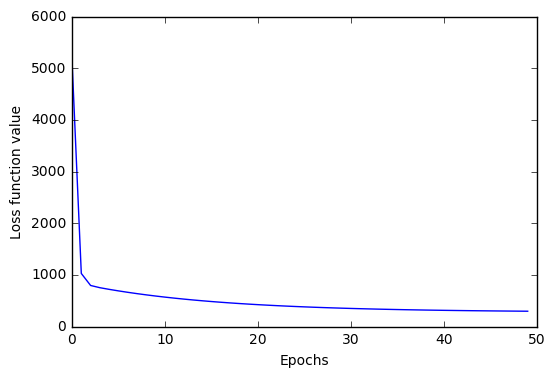

Optimized Coefficients: [[ 0.83994354]
 [ 3.9891303 ]
 [ 5.75055157]]
R squared score:  [ 0.95784595]


Gradient descent: batch with high learning rate and no adaptive learning


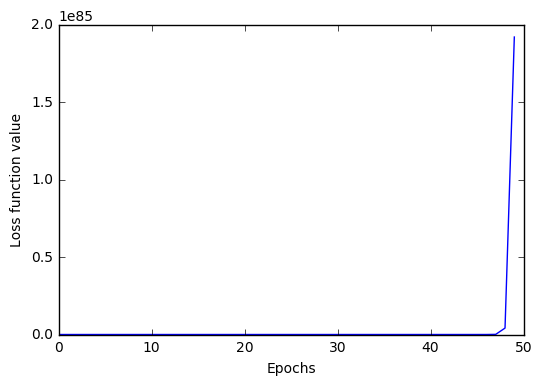

Optimized Coefficients: [[  1.80753823e+39]
 [ -1.50987852e+42]
 [  4.08921298e+39]]
R squared score:  [ -1.20097292e+83]


Gradient descent: batch with high learning rate and adaptive learning


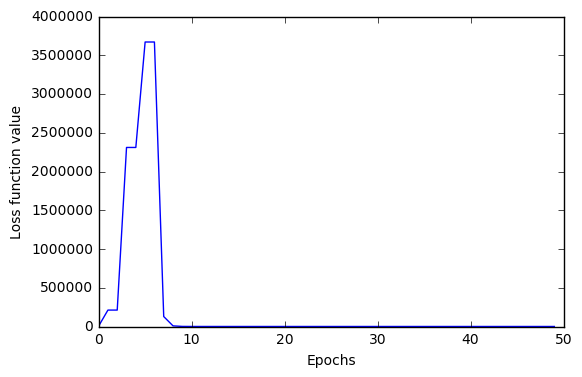

Optimized Coefficients: [[ 0.78488636]
 [ 3.99376625]
 [ 6.72821366]]
R squared score:  [ 0.96177163]


In [82]:
import random

def randomSampleGenerator(n):
    Y = []
    X = []
    random.seed(10)
    for i in range(1,n+1):
        x1 = random.uniform(-50, 50)
        x2 = random.uniform(-10, 10)
        var = random.random() * 50 * random.randint(-1, 1)
        y = (3 + 4 * x1 + 7 * x2) + var
        Y.append([y])
        X.append([1, x1, x2])
    return [np.array(X), np.array(Y)]

N_samples = 1000
[X, Y] = randomSampleGenerator(N_samples)
print('Sample function which is being predicted: y = 3 +4*x1 + 7*x2')
[X_train, Y_train ] = [X[0:int(0.7*N_samples),:], Y[0:int(0.7*N_samples)]]
[X_test, Y_test ] = [X[int(0.7*N_samples):N_samples,:], Y[int(0.7*N_samples):N_samples]]

GD = GradientDescent(epochs=50, lr=0.001)
print('\n\nGradient descent: batch with no adaptive learning')
coeff = GD.fit(X_train, Y_train)
print('Optimized Coefficients:', coeff)
Y_predict = GD.predict(X_test)
print('R squared score: ', GD.score(Y_test, Y_predict))

GD = GradientDescent(epochs=50, lr=0.01)
print('\n\nGradient descent: batch with high learning rate and no adaptive learning')
coeff = GD.fit(X_train, Y_train)
print('Optimized Coefficients:', coeff)
Y_predict = GD.predict(X_test)
print('R squared score: ', GD.score(Y_test, Y_predict))

GD = GradientDescent(epochs=50, lr=0.01, adaptive=True)
print('\n\nGradient descent: batch with high learning rate and adaptive learning')
coeff = GD.fit(X_train, Y_train)
print('Optimized Coefficients:', coeff)
Y_predict = GD.predict(X_test)
print('R squared score: ', GD.score(Y_test, Y_predict))

Sample function which is being predicted: y = 3 +4*x1 + 7*x2


Gradient descent: stochastic with no adaptive learning


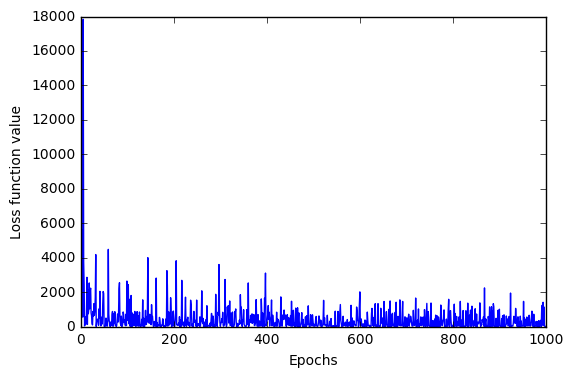

Optimized Coefficients: [[ 1.12922904]
 [ 4.09095477]
 [ 6.66528094]]
R squared score:  [ 0.96125941]


Gradient descent: stochastic with adaptive learning


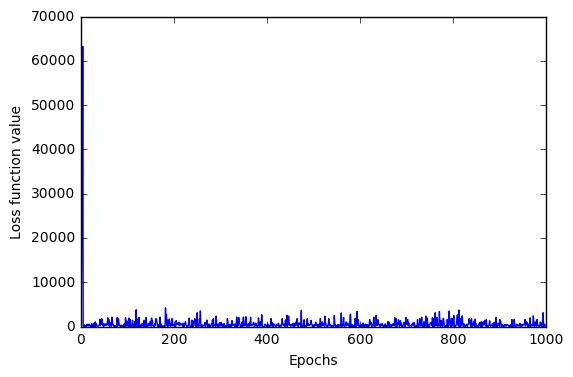

Optimized Coefficients: [[-1.20034195]
 [ 4.80547283]
 [ 7.12803966]]
R squared score:  [ 0.92488025]


In [83]:
N_samples = 1000
[X, Y] = randomSampleGenerator(N_samples)
print('Sample function which is being predicted: y = 3 +4*x1 + 7*x2')
[X_train, Y_train ] = [X[0:int(0.7*N_samples),:], Y[0:int(0.7*N_samples)]]
[X_test, Y_test ] = [X[int(0.7*N_samples):N_samples,:], Y[int(0.7*N_samples):N_samples]]

GD = GradientDescent(method='stochastic', epochs=1000, lr=0.0001)
print('\n\nGradient descent: stochastic with no adaptive learning')
coeff = GD.fit(X_train, Y_train)
print('Optimized Coefficients:', coeff)
Y_predict = GD.predict(X_test)
print('R squared score: ', GD.score(Y_test, Y_predict))

GD = GradientDescent(method='stochastic', epochs=1000, lr=0.01, adaptive=True)
print('\n\nGradient descent: stochastic with adaptive learning')
coeff = GD.fit(X_train, Y_train)
print('Optimized Coefficients:', coeff)
Y_predict = GD.predict(X_test)
print('R squared score: ', GD.score(Y_test, Y_predict))